## [21]: データを読み込んで把握

In [1]:
import pandas as pd

In [2]:
uselog = pd.read_csv("use_log.csv") # ジムの利用履歴データ、2018年4月～2019年3月
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [3]:
customer = pd.read_csv("customer_master.csv") # 2019年3月末時点での会員データ
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [4]:
class_master = pd.read_csv("class_master.csv") # 会員区分データ
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [5]:
campaign_master = pd.read_csv("campaign_master.csv") # キャンペーン区分データ
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


## [22]: 顧客データを整形

In [6]:
customer_join = pd.merge(customer, class_master, on = "class", how = "left") # 会員区分マスタと結合
customer_join = pd.merge(customer_join, campaign_master, on = "campaign_id", how = "left") # キャンペーン区分マスタと結合
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [7]:
print(len(customer))
print(len(customer_join))

4192
4192


In [8]:
customer_join.isnull().sum() # 欠損値の確認

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

## [23]: 顧客データの基礎集計

In [9]:
customer_join.groupby("class_name").count()["customer_id"] # 会員区分ごとの会員数を集計

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [10]:
customer_join.groupby("campaign_name").count()["customer_id"] # キャンペーン区分ごとの会員数を集計

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [11]:
customer_join.groupby("gender").count()["customer_id"] # 性別ごとの会員数を集計

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [12]:
customer_join.groupby("is_deleted").count()["customer_id"] # 退会ユーザー数を集計

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [13]:
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"]) # 開始日をdatetime型に変換
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")] # 開始日が2018年4月1日以降の会員を抽出
print(len(customer_start))

1361


## [24]: 最新顧客データの基礎集計

In [14]:
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"]) # 終了日をdatetime型に変換
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331"))|(customer_join["end_date"].isna())] # 終了日が2019年3月31日以降の会員を抽出
print(len(customer_newer))
customer_newer["end_date"].unique() # 終了日がNaTの会員を抽出

2953


<DatetimeArray>
['NaT', '2019-03-31 00:00:00']
Length: 2, dtype: datetime64[ns]

- ① customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
  - customer_join というデータフレームの end_date 列（退会日など）を、文字列 → 日付型（datetime）に変換しています。
  - これにより、後で日付の大小比較などができるようになります。
<br><br>
- ② customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
  - この部分は、**2019年3月31日以降に退会した人、または退会していない人（end_date が欠損値）**を抽出しています。
- customer_join["end_date"] >= pd.to_datetime("20190331")
  - → 2019年3月31日 以降の退会日（＝比較的新しい退会者）
- customer_join["end_date"].isna()
  - → end_date が NaN（= まだ退会していない顧客）
- | は または（OR） という意味です。
- つまり → 「最近まで在籍している、またはまだ辞めていない顧客」だけを抽出している。
<br><br>
- customer_newer["end_date"].unique()
  - 抽出されたデータの中で、end_date の**ユニークな値（重複なし一覧）**を表示しています。
  - つまり、どんな退会日が含まれているのかを確認するための処理です。

In [15]:
customer_newer.groupby("class_name").count()["customer_id"] # 会員区分ごとの会員数を集計

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [16]:
customer_newer.groupby("campaign_name").count()["customer_id"] # キャンペーン区分ごとの会員数を集計

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [17]:
customer_newer.groupby("gender").count()["customer_id"] # 性別ごとの会員数を集計

gender
F    1400
M    1553
Name: customer_id, dtype: int64

## [25]: 利用履歴データを集計

In [19]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"]) # 利用日をdatetime型に変換
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m") # 年月を抽出

uselog_months = uselog.groupby(["年月", "customer_id"], as_index = False).count() # 年月ごとの利用回数を集計
uselog_months.rename(columns = {"log_id": "count"}, inplace = True) # 列名を変更

del uselog_months["usedate"] # usedate列を削除
uselog_months.head() # 年月ごとの利用回数を集計したデータの確認

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


- 集計は log_id のカウントを取れば良いので、余分な usedate は削除してある。

In [21]:
uselog_months["count"] = pd.to_numeric(uselog_months["count"], errors="coerce") # count列を数値型に変換

uselog_customer = uselog_months.groupby("customer_id")["count"].agg(["mean","median", "max", "min"]) # 会員ごとの利用回数の平均、中央値、最大値、最小値を集計


uselog_customer = uselog_customer.reset_index(drop = False) # customer_idをインデックスから外す
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


- uselog_customer = uselog_months.groupby("customer_id").agg(["mean","median", "max", "min"])["count"]
  - 実行すると、TypeError: agg function failed [how->mean,dtype->object]というエラーが出た
  - このエラーは、agg(["mean", "median", "max", "min"]) を適用しようとしている列（この場合 "count"）が 数値型ではなく object型（文字列など）になっている ために発生しています。
<br><br>
### エラーの原因
- agg() で mean や median を使うためには、対象の列が 数値（intやfloat）型 である必要があります。
- object 型の列には平均や中央値などの統計処理ができず、以下のようなエラーになります：
  - TypeError: agg function failed [how->mean, dtype->object]
<br><br>
### ✅ 解決方法
- 「count」列を数値型に変換してから集計する
![解決コード](https://files.oaiusercontent.com/file-XrNevnzgXvta1YqpaSA16M?se=2025-04-23T06%3A24%3A11Z&sp=r&sv=2024-08-04&sr=b&rscc=max-age%3D299%2C%20immutable%2C%20private&rscd=attachment%3B%20filename%3Dca8d5ac2-127a-41e1-b29a-d947d9160af5&sig=aOFJMh%2B5sAj40HtQRyxr6QbuwYxwtsy/MQZWSsuWO24%3D)
  - pd.to_numeric(..., errors="coerce") は、数値に変換できないものを NaN にしてくれる関数です。
<br><br>
- ✅ おまけ：ワンライナー形式で書くなら
![おまけ](https://files09.oaiusercontent.com/file-YbVPnyUSHS1AJ7rMovFaQp?se=2025-04-23T06%3A19%3A12Z&sp=r&sv=2024-08-04&sr=b&rscc=max-age%3D299%2C%20immutable%2C%20private&rscd=attachment%3B%20filename%3D0b65dd70-6f2e-4e71-ad62-b1d5638bb3a7&sig=z8orURrWvp%2BFVlvxATcJXUPlGsZYw3LzBXID3ENobSo%3D)

## [26]: 利用履歴データから定期利用フラグを作成する

In [23]:
uselog["weekday"] = uselog["usedate"].dt.weekday # 曜日を抽出
uselog_weekday = uselog.groupby(["customer_id", "年月", "weekday"], as_index = False).count()[["customer_id", "年月", "weekday", "log_id"]] # 曜日ごとの利用回数を集計
uselog_weekday.rename(columns = {"log_id": "count"}, inplace = True) # 列名を変更
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1



---

### 1. 曜日を抽出
```python
uselog["weekday"] = uselog["usedate"].dt.weekday
```
- `uselog["usedate"]` は利用日を表す列で、`datetime` 型に変換済みです。
- `.dt.weekday` を使うことで、利用日の曜日を数値（0: 月曜日, 1: 火曜日, ..., 6: 日曜日）として取得します。
- 新しい列 `weekday` を作成し、曜日情報を格納します。

---

### 2. 曜日ごとの利用回数を集計
```python
uselog_weekday = uselog.groupby(["customer_id", "年月", "weekday"], as_index = False).count()[["customer_id", "年月", "weekday", "log_id"]]
```
- `groupby(["customer_id", "年月", "weekday"])`:
  - 利用履歴データを「顧客ID（`customer_id`）」「年月（`年月`）」「曜日（`weekday`）」の3つのキーでグループ化します。
- `.count()`:
  - 各グループ内で、指定された列（ここでは `log_id`）の件数をカウントします。
- `[["customer_id", "年月", "weekday", "log_id"]]`:
  - 必要な列（`customer_id`, `年月`, `weekday`, `log_id`）だけを抽出します。
- この結果、各顧客が特定の年月・曜日にジムを利用した回数が集計されます。

---

### 3. 列名を変更
```python
uselog_weekday.rename(columns = {"log_id": "count"}, inplace = True)
```
- 集計結果の列名 `log_id` を `count` に変更します。
- これにより、列の意味が「利用回数」であることが明確になります。

---

### 4. 集計結果の確認
```python
uselog_weekday.head()
```
- 集計結果の先頭5行を表示して、データの内容を確認します。

---

### 全体の流れ
このコードの目的は、「顧客ごとに、特定の年月・曜日にジムを利用した回数」を集計し、データフレーム `uselog_weekday` にまとめることです。これにより、曜日ごとの利用傾向を分析する準備が整います。


In [25]:
uselog_weekday = uselog_weekday.groupby("customer_id", as_index = False).max()[["customer_id", "count"]] # 曜日ごとの平均利用回数を集計
uselog_weekday["routine_flg"] = 0 # 曜日ごとの平均利用回数を集計したデータにフラグを追加
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1) # 曜日ごとの平均利用回数が4回以上の会員をフラグ1にする
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


このコードは、曜日ごとの利用回数データを基に「定期的に利用しているかどうか」を判定するフラグ（`routine_flg`）を作成しています。以下に各行の処理を解説します。

---

### 1. 顧客ごとの最大利用回数を取得
```python
uselog_weekday = uselog_weekday.groupby("customer_id", as_index = False).max()[["customer_id", "count"]]
```
- `groupby("customer_id")`:
  - 顧客ID（`customer_id`）ごとにデータをグループ化します。
- `.max()`:
  - 各顧客について、曜日ごとの利用回数（`count`）の最大値を取得します。
  - つまり、各顧客が最も多く利用した曜日の利用回数を抽出します。
- `[["customer_id", "count"]]`:
  - 必要な列（`customer_id` と `count`）だけを抽出します。
- 結果:
  - 各顧客の「最も多く利用した曜日の利用回数」がまとめられたデータフレームが作成されます。

---

### 2. 定期利用フラグの初期化
```python
uselog_weekday["routine_flg"] = 0
```
- 新しい列 `routine_flg` を作成し、初期値としてすべての行に `0` を設定します。
- この列は、後で「定期的に利用しているかどうか」を示すフラグとして使用されます。

---

### 3. 定期利用フラグの条件設定
```python
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1)
```
- `uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1)`:
  - `where` 関数を使用して、条件に応じて値を変更します。
  - 条件: `uselog_weekday["count"] < 4`
    - 利用回数が4回未満の場合、`routine_flg` をそのまま `0` にします。
    - 利用回数が4回以上の場合、`routine_flg` を `1` に変更します。
- 結果:
  - 利用回数が4回以上の顧客は「定期的に利用している」とみなされ、`routine_flg` が `1` になります。

---

### 4. データの確認
```python
uselog_weekday.head()
```
- 処理結果の先頭5行を表示して、データの内容を確認します。

---

### 全体の流れ
1. 各顧客について、最も多く利用した曜日の利用回数を取得。
2. 新しいフラグ列 `routine_flg` を作成し、初期値を `0` に設定。
3. 利用回数が4回以上の顧客に対して、`routine_flg` を `1` に変更。
4. 結果として、各顧客が「定期的に利用しているかどうか」を示すデータフレームが完成します。

## [27]: 顧客データと利用履歴データを結合する

In [28]:
customer_join = pd.merge(customer_join, uselog_customer, on = "customer_id", how = "left") # 利用回数の集計結果を結合
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on = "customer_id", how = "left") # 曜日ごとの平均利用回数を結合
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,...,min_x,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,...,2,4.833333,5.0,8,2,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,...,3,5.083333,5.0,7,3,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,...,3,4.583333,5.0,6,3,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,...,2,4.833333,4.5,7,2,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,...,1,3.916667,4.0,6,1,3.916667,4.0,6,1,1


In [29]:
customer_join.isnull().sum() # 欠損値の確認

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean_x              0
median_x            0
max_x               0
min_x               0
mean_y              0
median_y            0
max_y               0
min_y               0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

## [28]: 会員期間を計算する

In [30]:
from dateutil.relativedelta import relativedelta # 日付の差分を計算するためにdateutil.relativedeltaをインポート

customer_join["calc_date"] = customer_join["end_date"] # 終了日を基準にする
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430")) # 終了日がNaTの会員は2019年4月30日を基準にする
customer_join["membership_period"] = 0 # 会員期間を初期化

for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i]) # 開始日と終了日の差分を計算
    customer_join.loc[i, "membership_period"] = delta.years * 12 + delta.months # 年数と月数を合計して会員期間を計算

customer_join.head() # 会員期間を計算したデータの確認

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,...,median_y,max_y,min_y,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,...,5.0,8,2,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,...,5.0,7,3,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,...,5.0,6,3,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,...,4.5,7,2,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,...,4.0,6,1,3.916667,4.0,6,1,1,2019-04-30,47


このコードは、顧客データ（`customer_join`）に対して「会員期間（月数）」を計算する処理を行っています。以下に各行の処理をわかりやすく説明します。

---

### 1. 必要なライブラリのインポート
```python
from dateutil.relativedelta import relativedelta
```
- `relativedelta` は、2つの日付の差分を「年」「月」「日」単位で計算するためのライブラリです。

---

### 2. 終了日を基準にする
```python
customer_join["calc_date"] = customer_join["end_date"]
```
- 顧客データの終了日（`end_date`）を新しい列 `calc_date` にコピーします。
- `calc_date` は、会員期間を計算する際の基準日として使用されます。

---

### 3. 終了日が欠損値（NaT）の場合の処理
```python
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
```
- `calc_date` 列に欠損値（NaT）がある場合、それを「2019年4月30日」に置き換えます。
- これは、退会日が記録されていない（まだ退会していない）顧客の会員期間を計算するための処理です。

---

### 4. 会員期間列の初期化
```python
customer_join["membership_period"] = 0
```
- 新しい列 `membership_period` を作成し、初期値としてすべての行に `0` を設定します。
- この列に、後で計算した会員期間（月数）を格納します。

---

### 5. 会員期間の計算
```python
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join.loc[i, "membership_period"] = delta.years * 12 + delta.months
```
- `for` ループを使用して、各顧客の会員期間を計算します。
  1. `relativedelta` を使って、終了日（`calc_date`）と開始日（`start_date`）の差分を計算します。
     - 差分は「年」「月」「日」単位で取得されます。
  2. 差分の「年数」を月数に変換し（`delta.years * 12`）、差分の「月数」と合計します。
     - これにより、会員期間が「月数」で計算されます。
  3. 計算結果を `membership_period` 列に格納します。

---

### 6. 計算結果の確認
```python
customer_join.head()
```
- 処理結果の先頭5行を表示して、計算が正しく行われたかを確認します。

---

### 全体の流れ
1. 終了日（`end_date`）を基準日（`calc_date`）として設定。
2. 終了日が欠損している場合は「2019年4月30日」に置き換え。
3. 各顧客の開始日（`start_date`）と基準日（`calc_date`）の差分を計算。
4. 差分を月数に変換して、会員期間（`membership_period`）として保存。
5. 計算結果を確認。

このコードにより、各顧客の会員期間（月数）が計算され、データフレームに追加されます。

## [29]: 顧客行動の各種統計量を把握する

In [32]:
customer_join[["mean", "median", "max", "min"]].describe() # 利用回数の統計量を確認

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [33]:
customer_join.groupby("routine_flg").count()["customer_id"] # 曜日ごとの平均利用回数のフラグを集計

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

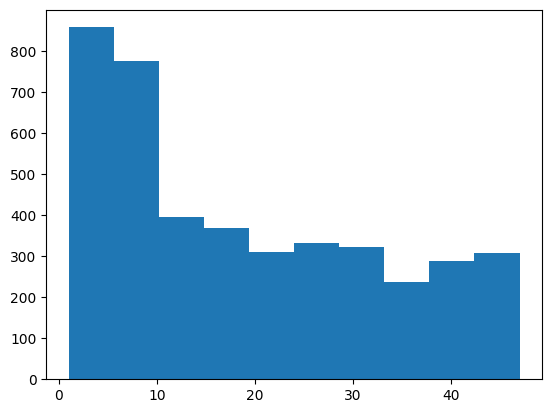

In [34]:
import matplotlib.pyplot as plt # グラフ描画のためにmatplotlib.pyplotをインポート

plt.hist(customer_join["membership_period"]) # 会員期間のヒストグラムを描画

## [30]: 退会ユーザーと継続ユーザーの違いを把握する

In [35]:
customer_end = customer_join.loc[customer_join["is_deleted"] == 1] # 退会ユーザーを抽出
customer_end.describe() # 退会ユーザーの統計量を確認

,start_date,end_date,is_deleted,price,mean_x,median_x,max_x,min_x,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg,calc_date,membership_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,3.865474,3.621852,6.461481,1.821481,3.865474,3.621852,6.461481,1.821481,0.456296,2018-10-17 16:23:28,8.026667
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,3.000000,3.000000,4.000000,1.000000,3.000000,3.000000,4.000000,1.000000,0.000000,2018-06-30 00:00:00,4.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,4.000000,4.000000,7.000000,2.000000,4.000000,4.000000,7.000000,2.000000,0.000000,2018-10-31 00:00:00,7.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,4.666667,4.500000,8.000000,2.000000,4.666667,4.500000,8.000000,2.000000,1.000000,2019-01-31 00:00:00,11.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,9.000000,9.000000,13.000000,8.000000,9.000000,9.000000,13.000000,8.000000,1.000000,2019-03-31 00:00:00,23.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,1.246385,1.270847,2.584021,0.976361,1.246385,1.270847,2.584021,0.976361,0.498271,NaN,5.033692


In [37]:
customer_stay = customer_join.loc[customer_join["is_deleted"] == 0] # 在籍ユーザーを抽出
customer_stay.describe() # 在籍ユーザーの統計量を確認

,start_date,end_date,is_deleted,price,mean_x,median_x,max_x,min_x,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg,calc_date,membership_period
count,2842,0,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842,2842.000000
mean,2017-04-03 22:42:28.627726848,NaT,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,6.030288,6.024279,8.471147,3.620690,6.030288,6.024279,8.471147,3.620690,0.984166,2019-04-30 00:00:00,23.970443
min,2015-05-01 00:00:00,NaT,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,3.166667,3.000000,5.000000,1.000000,3.166667,3.000000,5.000000,1.000000,0.000000,2019-04-30 00:00:00,1.000000
25%,2016-05-01 00:00:00,NaT,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,4.833333,5.000000,7.000000,2.000000,4.833333,5.000000,7.000000,2.000000,1.000000,2019-04-30 00:00:00,12.000000
50%,2017-04-01 00:00:00,NaT,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,5.583333,5.500000,8.000000,3.000000,5.583333,5.500000,8.000000,3.000000,1.000000,2019-04-30 00:00:00,24.000000
75%,2018-04-05 00:00:00,NaT,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,7.178030,7.000000,10.000000,5.000000,7.178030,7.000000,10.000000,5.000000,1.000000,2019-04-30 00:00:00,35.000000
max,2019-03-15 00:00:00,NaT,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,12.000000,12.000000,14.000000,12.000000,12.000000,12.000000,14.000000,12.000000,1.000000,2019-04-30 00:00:00,47.000000
std,NaN,NaN,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,1.553587,1.599765,1.571048,2.030488,1.553587,1.599765,1.571048,2.030488,0.124855,NaN,13.746761


In [39]:
customer_join.to_csv("customer_join.csv", index = False) # 結合したデータをCSVファイルに出力